# LSTM Training and Evaluation

This notebook is used to train and evaluate the LSTM model. The model is set up and trained on the data that are procuced by executing the ```data_preparation.ipynb``` notebook. The evaluation is done by calculating the mean absolute percentage error (MAPE) and variance ratio.

In [1]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import time
import pickle as pkl


import import_ipynb
import helper_functions

importing Jupyter notebook from helper_functions.ipynb


## Data Loading

The data are imported from the ```datasets/data.csv``` file, which is produced by the ```data_preparation.ipynb``` notebook. 

In [2]:
# load data from datasets/data.pkl
# if data is not available, remind user to run data_preprocessing.ipynb
if any(file not in os.listdir('datasets') for file in ['df.pkl', 'train.pkl', 'test.pkl', 'X_train.pkl', 'y_train.pkl', 'X_test.pkl', 'y_test.pkl']):
    print('Data not found! Please run data_preprocessing.ipynb to generate the necessary pkl files.')    
else:
    df = pkl.load(open('datasets/df.pkl', 'rb'))
    train = pkl.load(open('datasets/train.pkl', 'rb'))
    test = pkl.load(open('datasets/test.pkl', 'rb'))
    X_train = pkl.load(open('datasets/X_train.pkl', 'rb'))
    y_train = pkl.load(open('datasets/y_train.pkl', 'rb'))
    X_test = pkl.load(open('datasets/X_test.pkl', 'rb'))
    y_test = pkl.load(open('datasets/y_test.pkl', 'rb'))
    data = { 'df':df, 'train': train, 'test': test, 'X_train': X_train, 'y_train': y_train, 'X_test': X_test, 'y_test': y_test }


## Model Training

The `build_lstm` function is a specialized component of our machine learning pipeline, aimed at constructing and optimizing an LSTM model for forecasting time series data. This function encapsulates the entire process of model development, from building the architecture to training and validation.

### Function Structure and Capabilities:

- **Model Architecture**: The LSTM model consists of:
  - **LSTM Layer**: A layer with 200 units, using 'relu' activation, configured to process input sequences of shape [5 timesteps, 1 feature], capturing the temporal dynamics in the data.
  - **Dense Layers**: Sequentially arranged with 50 units and 'relu' activation followed by an output layer with 5 units corresponding to the forecast horizon.

- **Compilation**: The model is compiled using the 'adam' optimizer for efficient stochastic gradient descent and 'mse' (mean squared error) as the loss function, critical for regression tasks. It also tracks 'mae' (mean absolute error) and 'mape' (mean absolute percentage error) as performance metrics during training.

- **Training Process**:
  - **Batch Size and Epochs**: The model trains in batches of 32 over 25 epochs, allowing for iterative adjustment and learning from the training data.
  - **Validation**: Uses a separate validation dataset to monitor performance and avoid overfitting.
  - **Early Stopping**: Includes a callback to cease training if the validation loss does not improve for 10 consecutive epochs, preserving the best model encountered during training.

- **Performance Monitoring**: The function prints status updates during compilation and training, providing transparency into the model building process. The training time is recorded and displayed, offering insights into the computational efficiency.



In [3]:

def build_lstm(data, epochs=25, batch_size=32) -> tf.keras.Model:
    """
    Builds, compiles, and fits our LSTM baseline model.

    Args:
        data (dict): Dictionary containing training and testing data.
                     Should have keys 'X_train', 'y_train', 'X_test', 'y_test'.
        epochs (int): Number of epochs for training the model. Default is 25.
        batch_size (int): Batch size for training. Default is 32.

    Returns:
        model (tf.keras.Model): Compiled LSTM model.
        history (tf.keras.callbacks.History): Training history.
    """
    # Define model parameters
    n_timesteps, n_features, n_outputs = 5, 1, 5

    # Define early stopping callback
    callbacks = [tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]

    # Build LSTM model
    model = Sequential()
    model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(n_outputs))

    # Compile the model
    print('Compiling baseline model...')
    model.compile(optimizer='adam', loss='mse', metrics=['mae', 'mape'])

    # Fit the model
    print('Fitting model...')
    start = time.time()
    history = model.fit(data["X_train"], data["y_train"], batch_size=batch_size,
                        epochs=epochs, validation_data=(data["X_test"], data["y_test"]),
                        verbose=1, callbacks=callbacks)
    print('Training time:', time.time() - start)

    return model, history

In [4]:
model, history = build_lstm(data)
model.summary()


Compiling baseline model...
Fitting model...
Epoch 1/25
273/273 [==============================] - 5s 12ms/step - loss: 2.4825 - mae: 0.3809 - mape: 24.4812 - val_loss: 169.5034 - val_mae: 8.9831 - val_mape: 7.8266
Epoch 2/25
273/273 [==============================] - 3s 12ms/step - loss: 0.1109 - mae: 0.1432 - mape: 11.4482 - val_loss: 23.0841 - val_mae: 3.3289 - val_mape: 3.9904
Epoch 3/25
273/273 [==============================] - 4s 15ms/step - loss: 0.0919 - mae: 0.1276 - mape: 8.9466 - val_loss: 33.7172 - val_mae: 3.8206 - val_mape: 3.7406
Epoch 4/25
273/273 [==============================] - 3s 12ms/step - loss: 0.0805 - mae: 0.1196 - mape: 8.4309 - val_loss: 90.3569 - val_mae: 6.6464 - val_mape: 5.9006
Epoch 5/25
273/273 [==============================] - 4s 14ms/step - loss: 0.0951 - mae: 0.1320 - mape: 9.4660 - val_loss: 62.5220 - val_mae: 5.3886 - val_mape: 4.8447
Epoch 6/25
273/273 [==============================] - 3s 11ms/step - loss: 0.0766 - mae: 0.1166 - mape: 7.5536 -

## Model Evaluation

In [5]:
lstm_preds = helper_functions.PredictAndForecast(model, data["train"], data["test"])
lstm_evals = helper_functions.Evaluate(data["test"], lstm_preds.predictions)

# lstm_evals.mape, lstm_evals.var_ratio
print("LSTM MAPE: ", lstm_evals.mape)
print("LSTM Variance Ratio: ", lstm_evals.var_ratio)



LSTM MAPE:  0.0339541844594838
LSTM Variance Ratio:  0.0398467392903008


In [6]:
# Visualize predictions and actual values
def plot_results(test, preds, df, title_suffix=None, xlabel='AAPL stock Price'):
    """
    Plots training data in blue, actual values in red, and predictions in green,
    over time.
    """
    fig, ax = plt.subplots(figsize=(20,6))
    # x = df.Close[-498:].index
    plot_test = test[1:]
    plot_preds = preds[1:]
    # plot_test = np.array(plot_test)

    x = df[-(plot_test.shape[0]*plot_test.shape[1]):].index.to_numpy()
    plot_test = plot_test.reshape((plot_test.shape[0]*plot_test.shape[1], 1))
    plot_preds = plot_preds.reshape((plot_test.shape[0]*plot_test.shape[1], 1))
    ax.plot(x, plot_test, label='actual')
    ax.plot(x, plot_preds, label='preds')
    if title_suffix==None:
        ax.set_title('Predictions vs. Actual')
    else:
        ax.set_title(f'Predictions vs. Actual, {title_suffix}')
    ax.set_xlabel('Date')
    ax.set_ylabel(xlabel)
    ax.legend()
    plt.show()

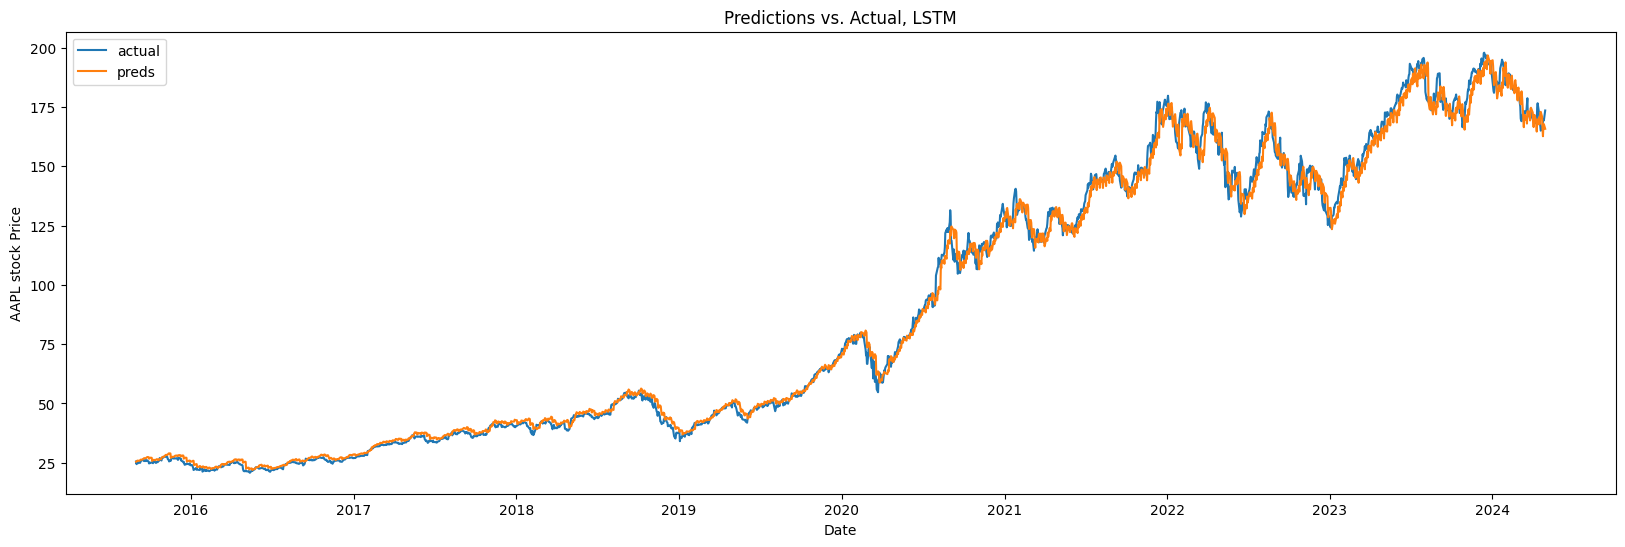

In [7]:
plot_results(data["test"], lstm_preds.predictions, data["df"], title_suffix='LSTM')